In [2]:
!pip install tqdm

     |████████████████████████████████| 71kB 2.2MB/s  eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
import numpy as np 
import pandas as pd 
import os
import keras
from keras import layers
from keras.preprocessing.image import load_img, save_img, img_to_array
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Dense,Dropout,Flatten
#from tqdm.auto import tqdm, trange
from tqdm import tqdm
from PIL import Image
import shutil
import s3fs
import cv2
import pickle as pk

In [4]:
def process_img(path, size=(64, 64)):
    with fs.open(f'{path}') as file:
        img = Image.open(file)
        img_arr = np.array(img).astype('float32')
        img_tensor = cv2.resize(img_arr, dsize=size, interpolation=cv2.INTER_CUBIC)
        img_final = np.interp(img_tensor, (img_tensor.min(), img_tensor.max()), (0, 1))
        if len(img_tensor.shape) != 3:
            img_final = np.zeros(size + (3,))
    return img_final

## **Only run the following cell if you need to load the data from a bucket** ##

In [14]:
fs = s3fs.S3FileSystem()
path = 's3://van-gogh-sagemaker/Vincent_van_Gogh/'
filelist = fs.ls(path)
paintings32 = np.array([process_img('s3://'+fname, size = (32, 32)) for fname in tqdm(filelist)])
paintings64 = np.array([process_img('s3://'+fname, size = (64, 64)) for fname in tqdm(filelist)])
pk.dump(paintings32, open('/home/ec2-user/SageMaker/images_pickle/van_gogh_images32.pkl','wb'))
pk.dump(paintings64, open('/home/ec2-user/SageMaker/images_pickle/van_gogh_images64.pkl','wb'))


100%|██████████| 877/877 [01:22<00:00, 10.67it/s]

100%|██████████| 877/877 [01:18<00:00, 11.14it/s]


In [6]:
paintings32 = pk.load(open('/home/ec2-user/SageMaker/images_pickle/van_gogh_images64.pkl','rb'))
paintings64 = pk.load(open('/home/ec2-user/SageMaker/images_pickle/van_gogh_images64.pkl','rb'))

In [9]:
paintings32.shape, paintings64.shape

((877, 64, 64, 3), (877, 64, 64, 3))

In [29]:
plt.imshow(paintings64[900])

IndexError: index 900 is out of bounds for axis 0 with size 877

In [10]:
latent_dim = 32
height = 64
width = 64
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 32 * 32)(generator_input)  #128 16x16 feature maps
x = layers.LeakyReLU()(x)
x = layers.Reshape((32, 32, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x) 
x = layers.LeakyReLU()(x)

'''
Upsamples to 128x128
'''
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x) 
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x) 
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x) 
'''
Instantiates the generator model, which maps the input
of shape (latent_dim,) into an image of shape (128, 128, 3)
'''
generator = keras.models.Model(generator_input, x) 
generator.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 131072)            4325376   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 131072)            0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 256)       1048832   
_______

In [11]:
discriminator_input = layers.Input(shape=(height, width, channels))

x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
'''
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
'''
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x) 
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0004,
                                                   clipvalue=1.0, 
                                                   decay=1e-8)


discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 128)       262272    
__________________________

In [12]:
discriminator.trainable = False  #Train only the generator for this part.
gan_input = keras.Input(shape=(latent_dim,)) 
gan_output = discriminator(generator(gan_input)) 
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8) 
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

x_train = paintings64

In [16]:
path = '/home/ec2-user/SageMaker/'
gan.load_weights(os.path.join(path, 'gan64.h5'))

In [ ]:
iterations = 2000
batch_size = 20
save_dir = '/home/ec2-user/SageMaker/van_gogh_art/'

start = 0
for step in tqdm(range(iterations)):
    
    #Samples random points in latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    #Decodes them to fake images
    generated_images = generator.predict(random_latent_vectors)
    
    stop = start + batch_size
    real_images = x_train[start:stop]
    combined_images = np.concatenate([generated_images, real_images])
    
    #Assembles labels, discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)), np.zeros((batch_size, 1))])
    
    #Adds random noise to the labels - an important trick. 
    labels += 0.05 * np.random.random(labels.shape)
    
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    
    '''
    Assembles labels that say "these are all real images" (it's a lie!)
    This is bc we want to reward the model if the discriminator guesses real. 
    This means discriminator is bad but generator is good; but we only care about
    updating the generator weights right now.
    '''
    misleading_targets = np.zeros((batch_size, 1))
    
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    if step % 100 ==0:
        gan.save_weights('/home/ec2-user/SageMaker/van_gogh_gan64.h5')
        
        print('discriminator loss: ', d_loss)
        print('adversarial loss: ', a_loss)
        
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_art64_' + str(step) + '.png'))
        
        img = image.array_to_img(real_images[0] * 255., scale = False)
        img.save(os.path.join(save_dir, 'real_art64_' + str(step) + '.png'))

  0%|          | 0/2000 [00:00<?, ?it/s]/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
  0%|          | 1/2000 [00:00<29:13,  1.14it/s]

discriminator loss:  0.5393951
adversarial loss:  0.95279753


  5%|▌         | 101/2000 [01:07<22:00,  1.44it/s]

discriminator loss:  0.65265065
adversarial loss:  2.6624045


 10%|█         | 201/2000 [02:13<20:51,  1.44it/s]

discriminator loss:  0.7413479
adversarial loss:  4.6139503


 15%|█▌        | 301/2000 [03:20<19:52,  1.43it/s]

discriminator loss:  0.6193855
adversarial loss:  1.2357228


 20%|██        | 401/2000 [04:27<18:36,  1.43it/s]

discriminator loss:  0.021657368
adversarial loss:  9.796942


 21%|██        | 417/2000 [04:38<17:38,  1.50it/s]

In [19]:
def make_art(num_of_images):
    random_latent_vectors = np.random.normal(size=(num_of_images, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    #imgs = image.array_to_img(generated_images[0] * 255., scale=False)
    #for a in range(len(generated_images))
    imgs = np.array([img for img in generated_images])
    return imgs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


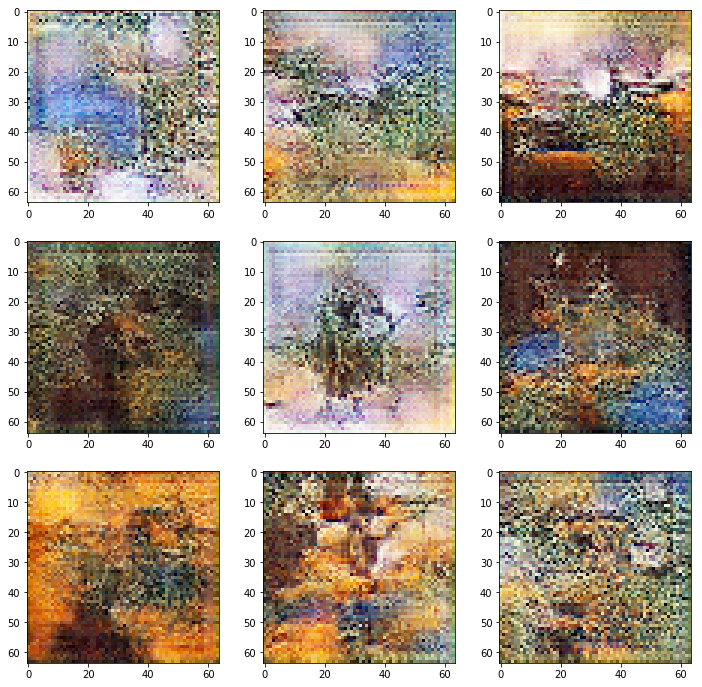

In [31]:
artwork = make_art(9)
fig, ax = plt.subplots(3,3, figsize=(12,12))
for a in range(9):
    ax[a//3, a%3].imshow(artwork[a])